In [1]:
import os
import b3d
import jax.numpy as jnp
import numpy as np
import h5py
import matplotlib.pyplot as plt
import trimesh
from b3d import Mesh, Pose

In [2]:
# paths for reading physion metadata
physion_assets_path = os.path.join(
    b3d.get_root_path(),
    "assets/physion/",)

stim_name = 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0006'

hdf5_file_path = os.path.join(physion_assets_path,
    f"hdf5s/{stim_name}.hdf5",
)

video_file_path = os.path.join(physion_assets_path,
    f"videos/{stim_name}_img.mp4",
)

In [3]:
def scale_mesh(vertices, scale_factor):
    vertices[:, 0] *= scale_factor[0]
    vertices[:, 1] *= scale_factor[1]
    vertices[:, 2] *= scale_factor[2]
    vertices[:,[2,1]] = vertices[:,[1,2]]
    return vertices

def quaternion_to_euler_angles(quaternion: np.ndarray) -> np.ndarray:
    """
    Convert a quaternion to Euler angles.

    Source: https://stackoverflow.com/a/12122899

    :param quaternion: A quaternion as a nump array.

    :return: The Euler angles representation of the quaternion.
    """
    _POLE: float = 0.49995
    x = quaternion[0]
    y = quaternion[1]
    z = quaternion[2]
    w = quaternion[3]

    sqx = x * x
    sqy = y * y
    sqz = z * z
    sqw = w * w

    unit = sqx + sqy + sqz + sqw
    test = x * w - y * z

    if test > _POLE * unit:
        ex = np.pi / 2
        ey = 2 * np.arctan2(y, x)
        ez = 0
    elif test < -_POLE * unit:
        ex = -np.pi / 2
        ey = -2 * np.arctan2(y, x)
        ez = 0
    else:
        qx = w
        qy = z
        qz = x
        qw = y
        sqqz = qz * qz
        ex = np.arcsin(2 * (qx * qz - qw * qy))
        ey = np.arctan2(2 * qx * qw + 2 * qy * qz, 1 - 2 * (sqqz + qw * qw))
        ez = np.arctan2(2 * qx * qy + 2 * qz * qw, 1 - 2 * (qy * qy + sqqz))
    return np.degrees(np.array([ex, ey, ez])) % 360

def euler_angles_to_quaternion(euler: np.ndarray) -> np.ndarray:
    """
    Convert Euler angles to a quaternion.

    Source: https://pastebin.com/riRLRvch

    :param euler: The Euler angles vector.

    :return: The quaternion representation of the Euler angles.
    """
    pitch = np.radians(euler[0] * 0.5)
    cp = np.cos(pitch)
    sp = np.sin(pitch)

    yaw = np.radians(euler[1] * 0.5)
    cy = np.cos(yaw)
    sy = np.sin(yaw)

    roll = np.radians(euler[2] * 0.5)
    cr = np.cos(roll)
    sr = np.sin(roll)

    x = sy * cp * sr + cy * sp * cr
    y = sy * cp * cr - cy * sp * sr
    z = cy * cp * sr - sy * sp * cr
    w = cy * cp * cr + sy * sp * sr
    return np.array([x, z, -y, w])

def compute_linear_velocity(last, now, dt):
    vel = (now-last)/dt
    return vel

## test whether linear velocity is the same as the center information

In [4]:
fps = b3d.io.utils.load_video_info(video_file_path).fps
delta_t = 1/fps
obj_idx = 2
recorded = []
computed = []

with h5py.File(hdf5_file_path, "r") as f:
    print(np.array(f['static']['model_names']))
    for key in f['frames'].keys():
        lin_vel = jnp.array(f['frames'][key]['objects']['velocities'])
        center_now = jnp.array(f['frames'][key]['objects']['center_cam0'])
        if key == '0000':
            continue
        frame_idx = int(key)
        center_last = jnp.array(f['frames'][str(frame_idx-1).zfill(4)]['objects']['center_cam0'])
        linear_velocity = compute_linear_velocity(center_last[obj_idx], center_now[obj_idx], delta_t)
        # linear_velocity = np.dot(linear_velocity, np.array([[0,0,1],[0,-1,0],[-1,0,0]]))
        # angular_velocity[[2,0]] = -angular_velocity[[0,2]]
        recorded.append(lin_vel[obj_idx])
        computed.append(linear_velocity)
recorded = np.array(recorded)
computed = np.array(computed)

[b'cube' b'cube' b'cube' b'vase_laura_deko_vase_set' b'vase_06']


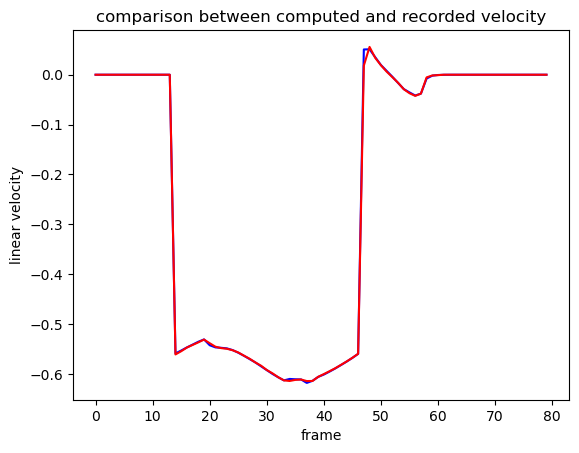

In [5]:
dim = 2

frames = [i for i in range(computed[:,0].shape[0])]

plt.plot(frames, recorded[:,dim], 'blue')
plt.plot(frames, computed[:,dim], 'red')
plt.xlabel("frame")
plt.ylabel("linear velocity")
plt.title('comparison between computed and recorded velocity')
plt.show()

## test whether center of mass is used to compute velocity

In [32]:
fps = b3d.io.utils.load_video_info(video_file_path).fps
delta_t = 1/fps
obj_idx = 2
recorded = []
computed = []

with h5py.File(hdf5_file_path, "r") as f:
    # extract object info
    object_ids = np.array(f['static']['object_ids'])
    model_names = np.array(f['static']['model_names'])
    distractors = np.array(f['static']['distractors']) if np.array(f['static']['distractors']).size != 0 else None if np.array(f['static']['distractors']).size != 0 else None
    occluders = np.array(f['static']['occluders']) if np.array(f['static']['occluders']).size != 0 else None if np.array(f['static']['occluders']).size != 0 else None
    
    excluded_model_ids = np.concatenate((np.where(model_names==distractors), np.where(model_names==occluders)), axis=0)
    included_model_names = [model_names[idx] for idx in range(len(object_ids)) if idx not in excluded_model_ids]
    included_model_ids = [object_ids[idx]-1 for idx in range(len(object_ids)) if idx not in excluded_model_ids]
    print(included_model_names, included_model_ids)

    scales = np.array(f['static']['scale'])
    meshes_faces = [np.array(f['static']['mesh'][f'faces_{idx}']) for idx in range(len(object_ids))]
    meshes_vertices = [np.array(f['static']['mesh'][f'vertices_{idx}']) for idx in range(len(object_ids))]
    object_scales = [scale for idx, scale in enumerate(scales) if idx in included_model_ids]
    object_meshes = [(scale_mesh(vertex, object_scales[idx]), face) for idx, (face, vertex) in enumerate(zip(meshes_faces, meshes_vertices)) if idx in included_model_ids]
    mesh_tri = trimesh.Trimesh(vertices=object_meshes[obj_idx][0], faces=object_meshes[obj_idx][1])
    mesh_b3d = b3d.Mesh.from_trimesh(mesh_tri)

    for key in f['frames'].keys():
        position = jnp.array(f['frames'][key]['objects']['positions_cam0'])
        rotation = jnp.array(f['frames'][key]['objects']['rotations_cam0'])
        object_positions = jnp.asarray([np.array([pos[0],pos[2],pos[1]]) for idx, pos in enumerate(position) if idx in included_model_ids])
        object_rotations = jnp.asarray([rot for idx, rot in enumerate(rotation) if idx in included_model_ids])
        # print(object_rotations[obj_idx])
        object_rotations = np.dot(object_rotations, np.array([[1,0,0,0],[0,0,1,0],[0,-1,0,0],[0,0,0,1]]))
        # object_rotations = np.dot(np.transpose(np.dot(object_rotations, np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]))), np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]))
        # object_rotations = euler_angles_to_quaternion(quaternion_to_euler_angles(object_rotations[obj_idx]))
        # print(object_rotations)
        # this is what we will get from b3d
        # object_pose = Pose(object_positions[obj_idx], object_rotations)
        object_pose = Pose(object_positions[obj_idx], object_rotations[obj_idx])
        # print(object_pose.position)


        mesh_transform = mesh_b3d.transform(object_pose)
        # print(mesh_transform)
        mesh_transform = trimesh.Trimesh(mesh_transform.vertices, mesh_transform.faces)
        # Compute the center of mass using trimesh's built-in function
        center_of_mass = mesh_transform.center_mass

        center_cam0 = jnp.array(f['frames'][key]['objects']['center_cam0'])
        object_center_cam0 = np.array([pos for idx, pos in enumerate(center_cam0) if idx in included_model_ids])
        object_center_cam0[:,[2,1]] = object_center_cam0[:,[1,2]]
        # print(object_center_cam0[obj_idx])
      
        recorded.append(object_center_cam0[obj_idx])
        computed.append(center_of_mass)
recorded = np.array(recorded)
computed = np.array(computed)

[b'cube', b'cube', b'cube'] [0, 1, 2]


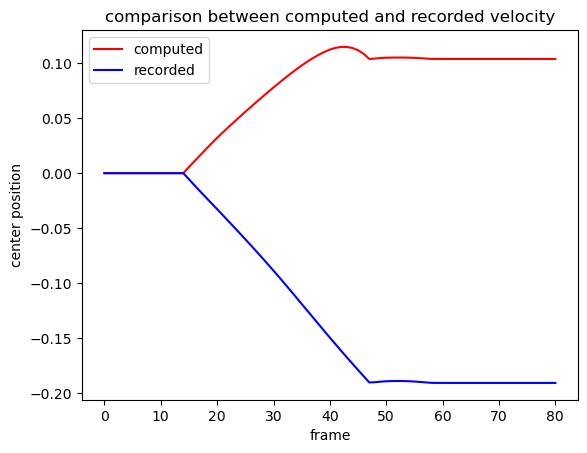

In [36]:
dim = 1

frames = [i for i in range(computed[:,0].shape[0])]

plt.plot(frames, computed[:,dim], 'red', label='computed')
plt.plot(frames, recorded[:,dim], 'blue', label='recorded')
plt.xlabel("frame")
plt.ylabel("center position")
plt.title('comparison between computed and recorded velocity')
plt.legend()
plt.show()